The 2019.03 RDKit release includes an optional integration with a semi-empirical quantum mechanics package called YAeHMOP. If you build the RDKit yourself, this is disabled by default, but I include it when I do the RDKit conda builds.

There's no documentation for this integration yet... thus this blog post.


## Some background

One of my major projects in grad school was to write a software package for performing extended Hueckel calculations and analyzing and visualizing the results. I released the source for YAeHMOP ("Yet Another extended Hueckel Molecular Orbital Package") way back when using some weird license (the open-source landscape in chemistry was "a bit" different back in the mid-90s). After changing fields, I more or less forgot about YAeHMOP until a couple of years ago when Patrick Avery contacted me about integrating it [into Avogadro](https://pubs.acs.org/doi/abs/10.1021/acs.jchemed.7b00698). To make things easier, I put the source [up on Github](https://github.com/greglandrum/yaehmop) and switched to a BSD license. Since that point we've done a bit of additional cleanup work on the eHT code (the visualization pieces are still there, but really only have historic interest) and made it useable as a library.

There are a couple of applications where I think it might be interesting to have access to quick, interpretable QM results from the RDKit. These include getting partial charges and starting to think about quick and dirty descriptors for things like bond strengths and reactivity. So I decided to do an integration of YAeHMOP into the RDKit.

There are a *bunch* of books and papers describing extended Hueckel theory and the various types of analysis that one can do with it; I'm not going to cite all of those here. There's also no formal publication describing YAeHMOP (what a shock!), but there is a [chapter](https://drive.google.com/open?id=0BzBynnwxNS0SanJzUkJYYWNFY0h1bzNFR0d0aVBCR0x5NmZV) in my PhD thesis that provides an fairly comprehensive tutorial overview of the theory.


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

# this is the package including the connection to YAeHMOP
from rdkit.Chem import rdEHTTools
from rdkit.Chem import AllChem
import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())


2019.09.1dev1
Tue Jun  4 09:40:01 2019


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Start by showing how to run an eHT calculation:

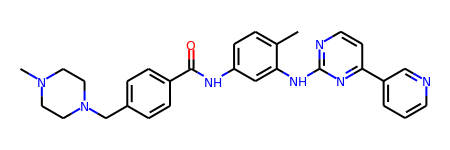

In [3]:
# imatinib
m = Chem.MolFromSmiles('Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1')
m

We need to add Hs and generate a conformation:

In [4]:
mh = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(mh,50);

In [5]:
passed,res = rdEHTTools.RunMol(mh)

The first return value lets us know if the calculation succeeded:

In [6]:
passed

True

The second contains the results of the calculation:

In [7]:
res

We have access to the atomic charges:

In [8]:
res.GetAtomicCharges()

array([-4.76731370e-02, -1.82554407e-02, -4.19458147e-02, -1.22902698e-01,
        2.77950581e-01, -2.61806452e-01,  9.99377802e-01, -1.21974534e+00,
        1.34268202e-02, -2.32647560e-03, -5.91813840e-02,  7.73620993e-02,
        2.45477608e-01, -6.05239709e-01,  1.96875689e-01,  2.19275477e-01,
       -5.98947692e-01,  1.97951512e-01,  2.26523907e-01,  1.97779580e-01,
       -4.75784926e-02, -2.46739720e-04, -1.61793445e-01,  2.82286112e-01,
       -3.49019873e-01,  9.25183814e-01, -8.91513014e-01,  4.28411229e-01,
       -1.75792605e-01,  4.90044802e-01,  1.44798454e-02,  1.08341110e-01,
       -7.09763175e-02,  3.66440853e-01, -8.24839688e-01,  3.66154631e-01,
       -8.92945852e-01,  2.62834808e-02,  1.06946764e-02,  1.74631614e-02,
        1.25255149e-02,  2.44540515e-02,  2.15489103e-01,  2.70510531e-02,
        2.64733442e-02, -1.54172953e-02, -1.76464578e-02,  5.84765500e-03,
        8.41373067e-04, -4.58589987e-03, -3.51196182e-03, -8.61968874e-03,
        1.67566170e-03,  

The reduced overlap population matrix provides the Mulliken overlap population between atoms in the molecule. It's returned as a vector representing a symmetric matrix:

In [9]:
res.GetReducedOverlapPopulationMatrix()[:6]

array([ 2.57813695,  0.79585516,  2.78412494, -0.08233683,  1.1324619 ,
        2.72546329])

In [10]:
# convenience function to set a "MulilkenOverlapPopulation" property on bonds.
def set_overlap_populations(m,ehtRes):
    rop = ehtRes.GetReducedOverlapPopulationMatrix()
    for bnd in m.GetBonds():
        a1 = bnd.GetBeginAtom()
        a2 = bnd.GetEndAtom()
        if a1.GetAtomicNum()==1:
            continue
        if a2.GetAtomicNum()==1:
            continue
        # symmetric matrix:
        i1 = max(a1.GetIdx(),a2.GetIdx())
        i2 = min(a1.GetIdx(),a2.GetIdx())
        idx = (i1*(i1+1))//2 + i2
        bnd.SetDoubleProp("MullikenOverlapPopulation",rop[idx])


In [11]:
set_overlap_populations(mh,res)

Look at a few of the overlap populations:

In [12]:
for bnd in list(mh.GetBonds())[:5]:
    if not bnd.HasProp("MullikenOverlapPopulation"):
        continue
    print(f'{bnd.GetIdx()} {bnd.GetBeginAtom().GetSymbol()}({bnd.GetBeginAtomIdx()})-{bnd.GetEndAtom().GetSymbol()}({bnd.GetEndAtomIdx()}) {bnd.GetBondType()} {bnd.GetDoubleProp("MullikenOverlapPopulation") :.3f}')

0 C(0)-C(1) SINGLE 0.796
1 C(1)-C(2) AROMATIC 1.132
2 C(2)-C(3) AROMATIC 1.088
3 C(3)-C(4) AROMATIC 1.109
4 C(4)-N(5) SINGLE 0.785


The wrapper also currently provides the reduced charge matrix (described in that thesis chapter linked above). I'm not going to discuss that here.

# Look at variability of charges between conformers

The rest of this blog post is going to show a straightforward analysis one can do with the eHT results: looking at the variability of the QM charges across the different conformers.

In [13]:
def runEHT(mh):
    """ convenience function to run an eHT calculation on all of a molecule's conformers
    
        returns a list of the results structures as well as a list of lists containing the
        charges on each atom in each conformer: chgs[atomId][confId] to use this
    """
    eres = []
    charges = [[] for x in range(mh.GetNumHeavyAtoms())]
    for cid in range(mh.GetNumConformers()):
        passed,res = rdEHTTools.RunMol(mh,confId=cid)
        eres.append(res)
        if not passed:
            raise ValueError("eHT failed")
        hvyIdx = 0
        echgs = res.GetAtomicCharges()
        for atom in mh.GetAtoms():
            if atom.GetAtomicNum()==1:
                continue
            charges[hvyIdx].append(echgs[atom.GetIdx()])
            hvyIdx+=1
    return (eres,charges)
    

In [14]:
eres,charges = runEHT(mh)

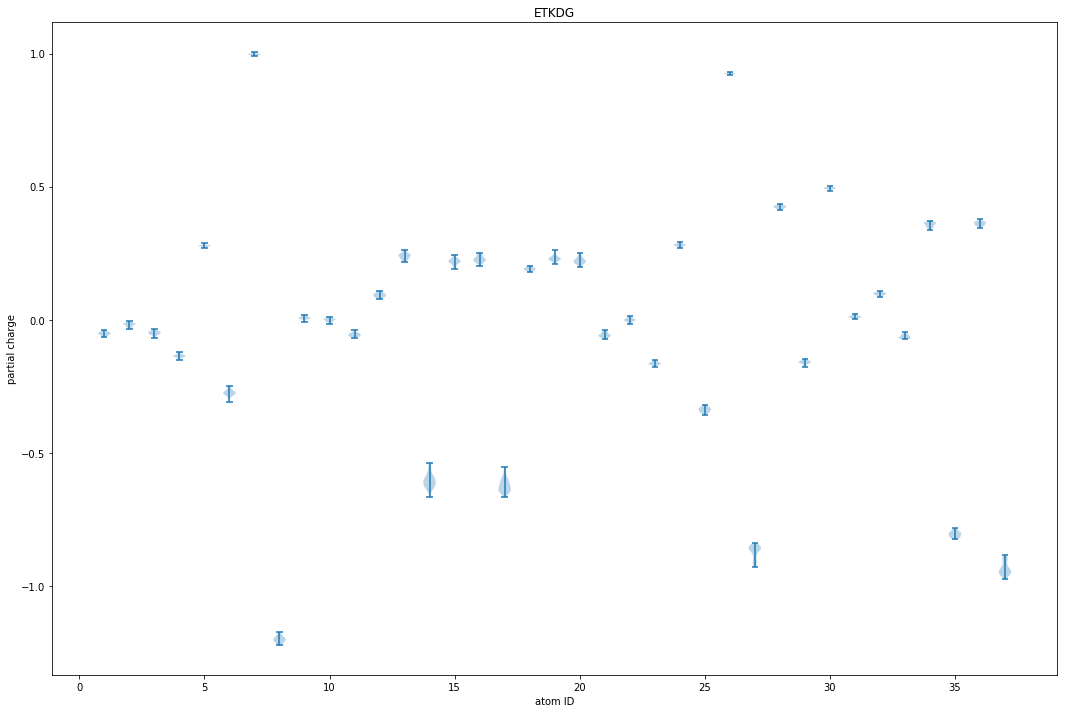

In [15]:
figsize(18,12)
violinplot(charges);
title("ETKDG");
xlabel('atom ID');
ylabel("partial charge");

To make sense of that, draw the molecule with the atoms numbered:

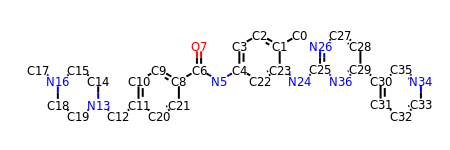

In [16]:
for at in m.GetAtoms():
    at.SetProp("atomLabel",f'{at.GetSymbol()}{at.GetIdx()}')
m

Look at the results for a couple of the atoms that show the most variability

In [17]:
tchgs = sorted((y,x) for x,y in enumerate(charges[13]))
tchgs[:2],tchgs[-2:]

([(-0.6664029226533725, 6), (-0.6487594694999941, 48)],
 [(-0.5445165709857742, 17), (-0.5391876949925227, 16)])

In [18]:
tchgs = sorted((y,x) for x,y in enumerate(charges[16]))
tchgs[:2],tchgs[-2:]

([(-0.6676496478129459, 1), (-0.6527095571768977, 4)],
 [(-0.5638332674055451, 24), (-0.5547888563594043, 29)])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

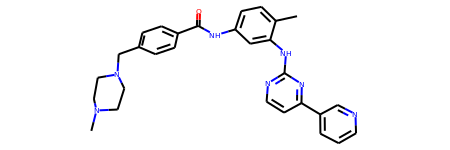

In [19]:
tm1 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=1))
tm1

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

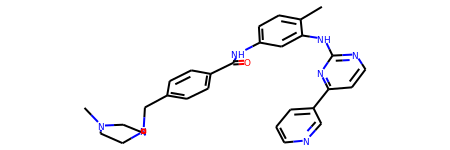

In [20]:
tm24 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=24))
tm24

The difference here is the conformation of the piperazine ring. In the first case (more negative N), the ring is in the chair form. In the second (less negative N), it's in the boat form. 

In [21]:
tchgs = sorted((y,x) for x,y in enumerate(charges[36]))
tchgs[:2],tchgs[-2:]

([(-0.9757653597847145, 5), (-0.964269062711359, 39)],
 [(-0.8904366087667777, 2), (-0.8853126618481291, 25)])

In [22]:
tchgs = sorted((y,x) for x,y in enumerate(charges[26]))
tchgs[:2],tchgs[-2:]

([(-0.9293420950223661, 2), (-0.9219185034197492, 11)],
 [(-0.8418499076836206, 10), (-0.8396288024312968, 37)])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

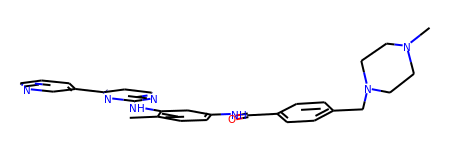

In [23]:
tm5 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=5))
tm5

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

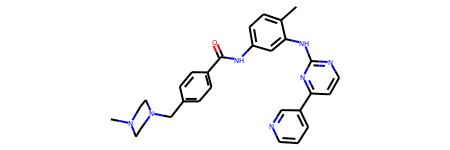

In [24]:
tm2 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh,confId=2))
tm2

The difference here is the orientation of the two Ns in the pyrimidine ring relative to the H on the exocyclic amine (atom 24). The N that is closer to the H has a more negative charge than the other.

What if we do an MMFF minimization of each conformer?

In [25]:
mh_mmff = Chem.Mol(mh)
optRes = AllChem.MMFFOptimizeMoleculeConfs(mh_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = AllChem.MMFFOptimizeMolecule(mh_mmff,maxIters=500,confId=i)


In [26]:
eres,mmff_charges = runEHT(mh_mmff)

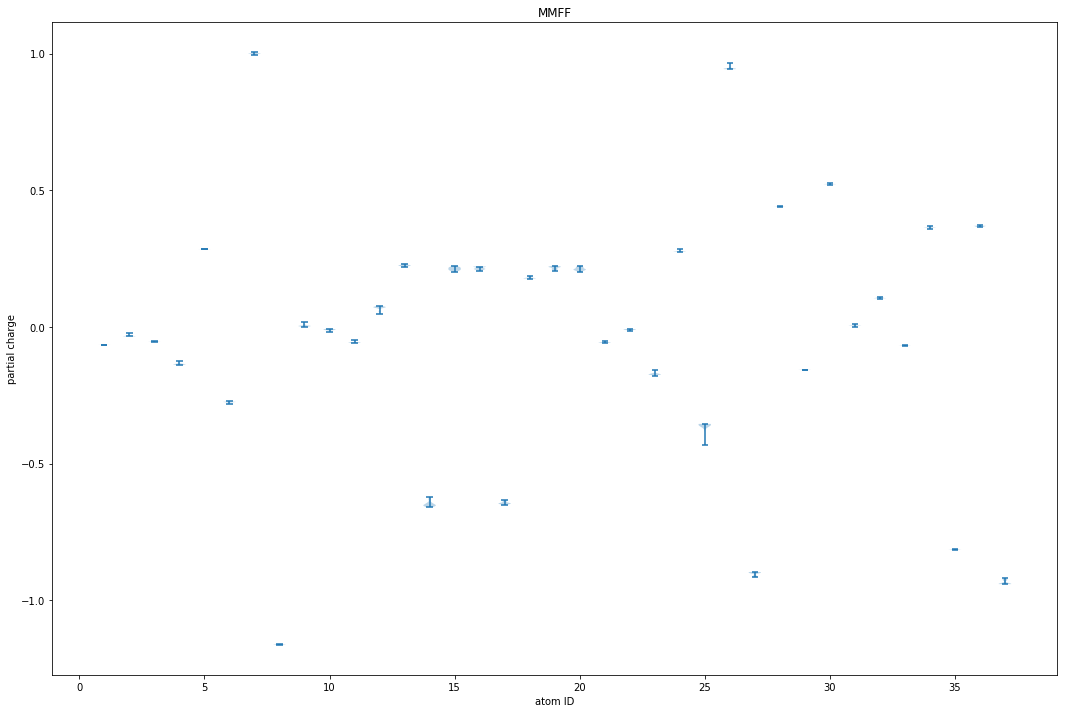

In [27]:
figsize(18,12)
violinplot(mmff_charges);
title("MMFF");
xlabel('atom ID');
ylabel("partial charge");

Are the MMFF conformers actually different from each other?

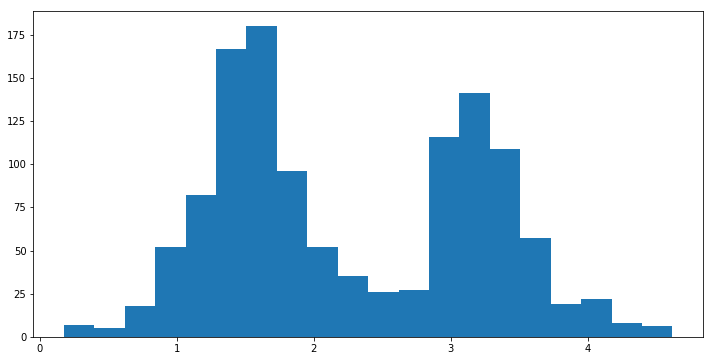

In [28]:
rmsds = []
cp1 = Chem.RemoveHs(mh_mmff)
cp2 = Chem.RemoveHs(mh_mmff)
for i in range(mh_mmff.GetNumConformers()):
    for j in range(i+1,mh_mmff.GetNumConformers()):
        rmsds.append(AllChem.GetBestRMS(cp1,cp2,prbId=i,refId=j))
figsize(12,6)
hist(rmsds,bins=20);

The inter-conformer charge differences we saw before have vanished, are the structural features still different?

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

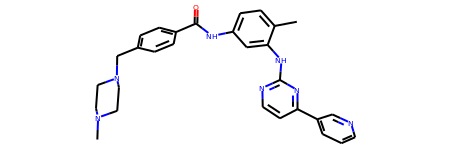

In [29]:
tm1 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=1))
tm1

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

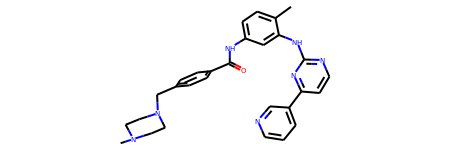

In [30]:
tm24 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=24))
tm24

Nope, both piperazine rings are now chair. That explains the charges being more or less constant

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

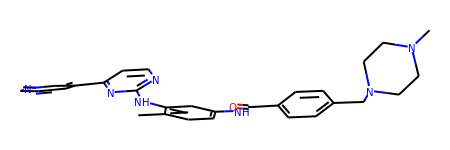

In [31]:
tm5 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=5))
tm5

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

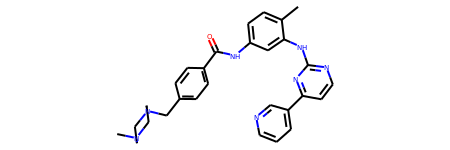

In [32]:
tm2 = Chem.MolFromMolBlock(Chem.MolToMolBlock(mh_mmff,confId=2))
tm2

Here the difference in the conformations is still present; the charge differences are just much smaller than previously

What about differences in charges between the conformation generation methods?

In [33]:
charge_compare = []
for i in range(len(charges)):
    both = list(zip(charges[i],mmff_charges[i]))
    charge_compare.extend(both)

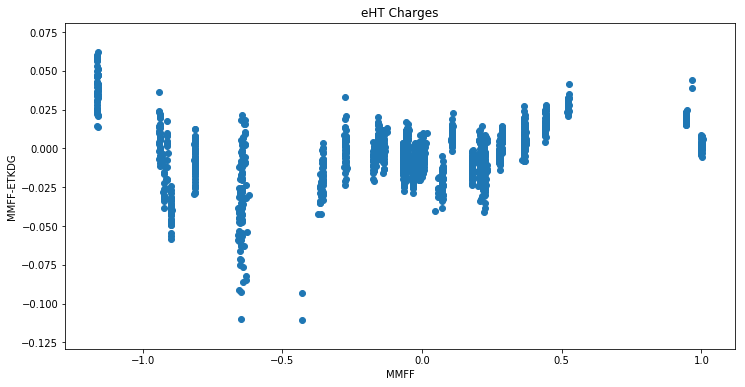

In [34]:
scatter([y for x,y in charge_compare],[y-x for x,y in charge_compare])
xlabel('MMFF')
ylabel('MMFF-ETKDG');
title('eHT Charges');


There are differences, but they are mostly reasonably small.

# Repeat that analysis for another molecule

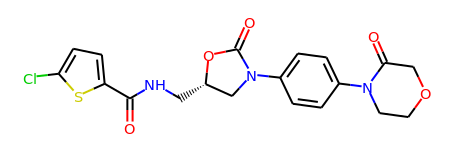

In [35]:
# rivaroxaban
m2 = Chem.MolFromSmiles('O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1ccc(Cl)s1')
m2

In [36]:
mh2 = Chem.AddHs(m2)
AllChem.EmbedMultipleConfs(mh2,50)
mh2_mmff = Chem.Mol(mh2)
optRes = AllChem.MMFFOptimizeMoleculeConfs(mh2_mmff,maxIters=500)
for i,needsMore in enumerate(optRes):
    while needsMore:
        needsMore = AllChem.MMFFOptimizeMolecule(mh2_mmff,maxIters=500,confId=i)


In [37]:
eres,charges2 = runEHT(mh2)
eres,mmff_charges2 = runEHT(mh2_mmff)


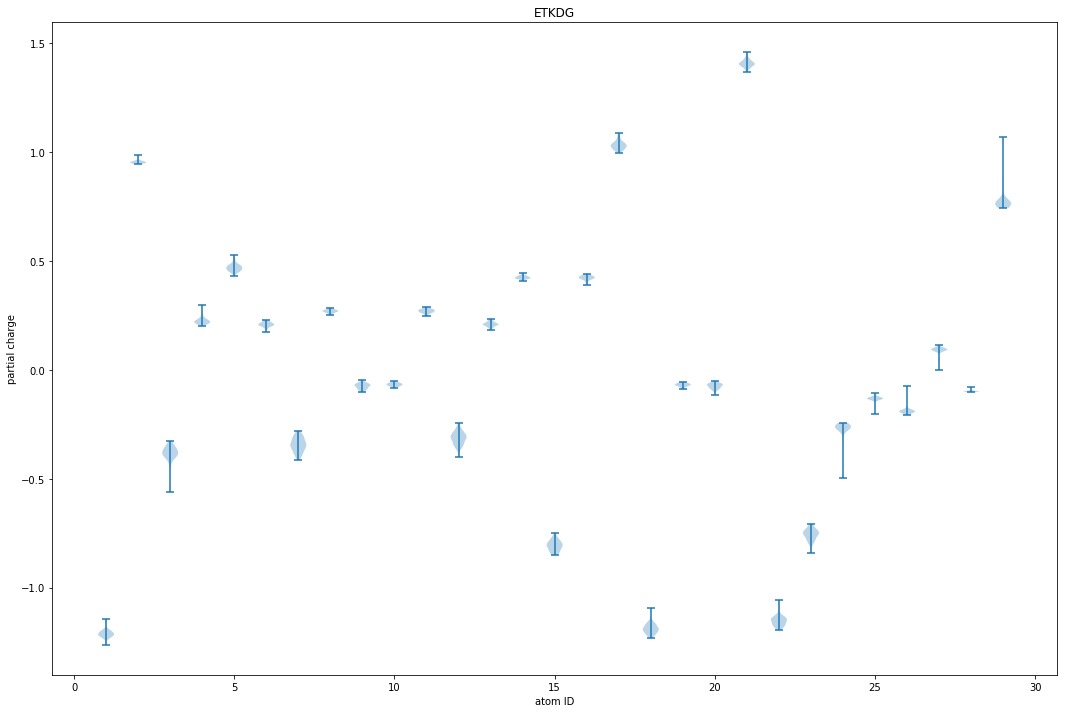

In [38]:
figsize(18,12)
violinplot(charges2);
title("ETKDG");
xlabel('atom ID');
ylabel("partial charge");

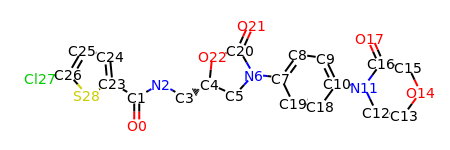

In [39]:
for at in m2.GetAtoms():
    at.SetProp("atomLabel",f'{at.GetSymbol()}{at.GetIdx()}')
m2

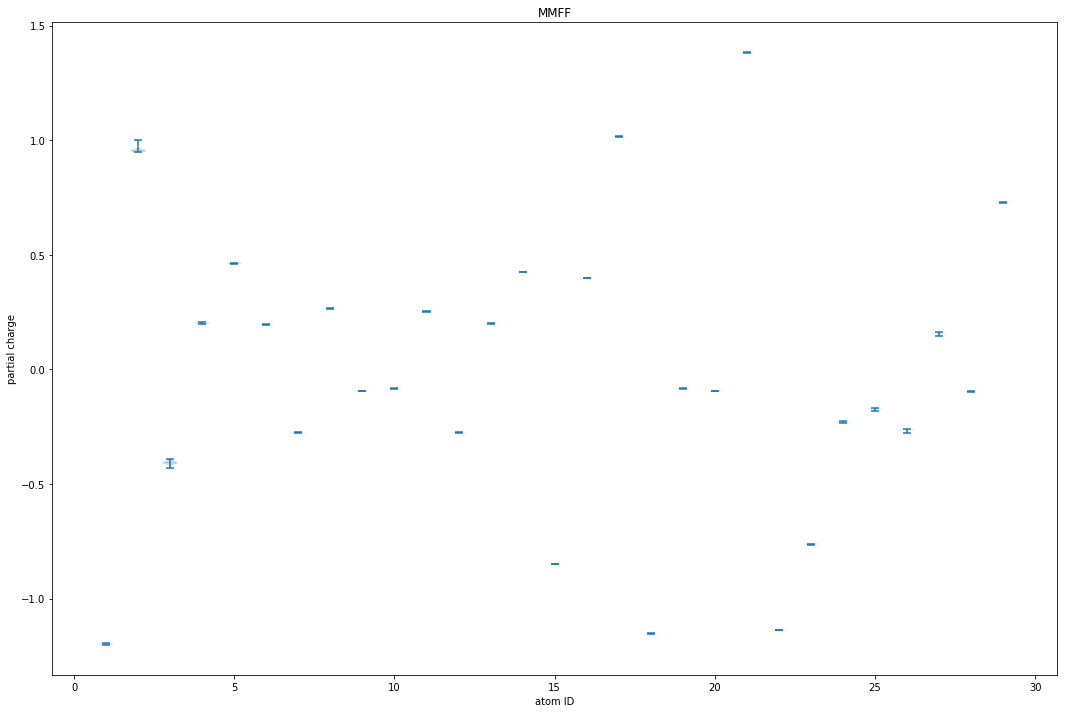

In [40]:
figsize(18,12)
violinplot(mmff_charges2);
title("MMFF");
xlabel('atom ID');
ylabel("partial charge");

Are the MMFF conformers actually different?

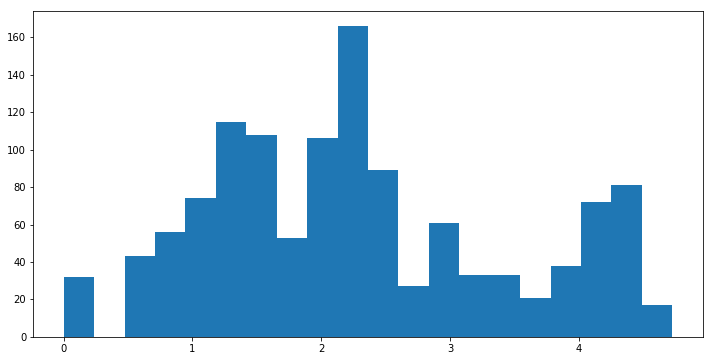

In [41]:
rmsds = []
cp1 = Chem.RemoveHs(mh2_mmff)
cp2 = Chem.RemoveHs(mh2_mmff)
for i in range(mh2_mmff.GetNumConformers()):
    for j in range(i+1,mh2_mmff.GetNumConformers()):
        rmsds.append(AllChem.GetBestRMS(cp1,cp2,prbId=i,refId=j))
figsize(12,6)
hist(rmsds,bins=20);

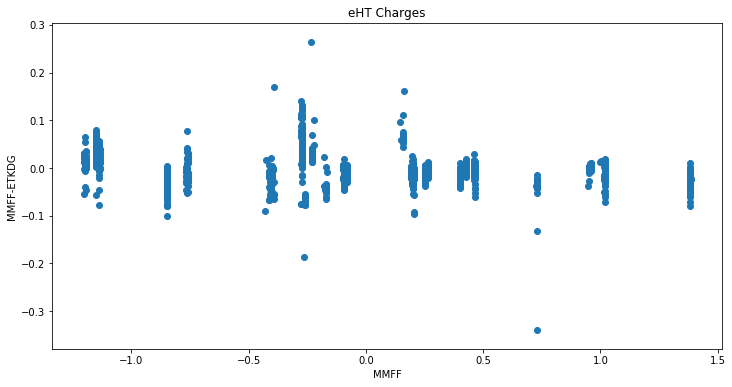

In [42]:
charge_compare2 = []
for i in range(len(charges2)):
    both = list(zip(charges2[i],mmff_charges2[i]))
    charge_compare2.extend(both)
scatter([y for x,y in charge_compare2],[y-x for x,y in charge_compare2])
xlabel('MMFF')
ylabel('MMFF-ETKDG');
title('eHT Charges');


Larger differences between conformation-generation methods here.

## Performance

How long does it take to do this analysis?

Start by looking at the time required to generate a conformer:

In [44]:
tempM = Chem.Mol(mh2)
%timeit _ = AllChem.EmbedMolecule(tempM)

47.6 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Or to generate a conformer and MMFF minimize it:

In [47]:
%timeit _ = AllChem.EmbedMolecule(tempM);AllChem.MMFFOptimizeMolecule(tempM,maxIters=500)

114 ms ± 6.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Do the eHT calculation:

In [48]:
%timeit _ = rdEHTTools.RunMol(tempM)

156 ms ± 859 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we can generate a conformer for rivaroxaban, MMFF minimize it, and then do the eHT calculation to get, for example, partial charges (remember these don't seem to change that much across MMFF conformers) in a bit more than 1/4 of a second. Not bad!